In [1]:
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="HeNPARP7EmQTxxVRpewzuqm8b",
    project_name="face-normal-liveness",
    workspace="ahmadirfaan",
)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/home/mamad/Desktop/Liveness/Normal Liveness' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/ahmadirfaan/face-normal-liveness/6bf194d9c9a3448a99431f3fd60cbf4a



# Import Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
device

device(type='cuda')

# Dataset and Dataloader

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [4]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_train = datasets.ImageFolder("train", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)
val_size = int(len(data_train) * 0.15)
train_size = len(data_train) - (val_size)

train_set, val_set = random_split(
    data_train,
    [train_size, val_size]
)

trainloader = DataLoader(train_set, batch_size=bs)
valloader = DataLoader(val_set, batch_size=bs)

In [5]:
len(train_set), len(val_set)

(18015, 3179)

In [6]:
label2cat = data_train.classes
label2cat

['0_spoof', '1_live']

# Architecture and Config

In [7]:
import torch
from torch import nn
import timm

class ConvNext(nn.Module):
    def __init__(self, output_size=2):
        super().__init__()
        self.basemodel = timm.create_model("convnext_base", pretrained=True)
#         self.basemodel.set_swish(memory_efficient=False)
#         self.basemodel
        self.freeze()
        self.basemodel.head.fc = nn.Sequential(
            nn.Linear(1024, output_size)
        )
        
#         self.basemodel.classifier = nn.Sequential(
#             nn.Linear(512, output_size),
#             nn.LogSoftmax(dim=1)
#         )
    
    def forward(self, x):
        x = self.basemodel(x)
        return x

    def freeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = False # Freezing Weight
    
    def unfreeze(self):
        for param in self.basemodel.parameters():
            param.requires_grad = True # Unfreezing Weight

    def predict(self, x):
        with torch.no_grad():
            self.basemodel.eval()
            output = self.basemodel(x)
            preds = output.argmax(1)
        return preds

In [8]:
config = set_config({
    "output_size": len(data_train.classes),
    "batch_size": bs,
    "crop_size": crop_size
})

# Training

In [9]:
from collections import Counter

In [20]:
def get_conf_matrix(output, target):
    output, target = output.detach().cpu().numpy(), target.detach().cpu().numpy()
    fp = fn = tp = tn = 0
    for out, t in zip(output, target):
        o = out.argmax()
        if(o==1 and t==1):
            tp+=1
        if(o==1 and t==0):
            fp+=1
        if(o==0 and t==1):
            fn+=1
        if(o==0 and t==0):
            tn+=0
    return tn, fp, fn, tp

In [12]:
model = ConvNext(2).to(device)
# model.unfreeze()

In [13]:
def countWeightForClass(n_samples,
                n_classes,
                n_samples_with_class):
    return n_samples / (n_classes * n_samples_with_class)

In [14]:
def countWeight(data_train):
    counter = Counter(data_train.targets)
    labels_count = dict(counter)
    lst = []
    for k in sorted(labels_count):
        lst.append(labels_count[k])
    n_samples = sum(lst)
    n_classes = len(data_train.classes)
    weight = []
    for n_samples_with_class in lst:
        weight.append(countWeightForClass(n_samples, n_classes, n_samples_with_class))
    return weight

In [15]:
weight = countWeight(data_train)
weight

[0.6393749245806685, 2.2937229437229436]

In [16]:
criterion = nn.CrossEntropyLoss(torch.tensor(weight).to(device))
# criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step_size=3, gamma=0.1)
callback = Callback(model, config, early_stop_patience=4, outdir="model")

In [17]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [22]:
from tqdm.auto import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device, experiment, epoch, step):
    if mode == "train":
        model.train()
        cost = correct = total = 0
        tp = fp = tn = fn = 0
        for feature, target in tqdm(dataloader, desc=mode.title()):
            feature, target = feature.to(device), target.to(device)
            total += len(feature)
            output = model(feature)
            loss = criterion(output, target)
            if mode == "train":
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

            cost += loss.item() * feature.shape[0]
            correct += (output.argmax(1) == target).sum().item()
    #         print(target)
    #         cf_matrix = confusion_matrix(target.cpu().numpy(), output.argmax(1).cpu().numpy())
    #         tn_temp, fp_temp, fn_temp, tp_temp = cf_matrix.ravel()
#             experiment.log_metric("train_step_accuracy", correct / total, step=step)
#             experiment.log_metric("train_step_loss", cost / total, step=step)
            step+=1
        cost = cost / len(dataset)
        acc = correct / len(dataset)
#         experiment.log_metric("train_accuracy", acc, epoch=epoch)
#         experiment.log_metric("train_loss", cost, epoch=epoch)
        return cost, acc, epoch, step
    elif mode == "test":
        model.eval()
        targets, preds_out, probs = predict(model, dataloader, device)
        acc = accuracy_score(targets, preds_out)
        cost = criterion(torch.tensor(probs).to(device), torch.tensor(targets).to(device))
#         cost = cost / len(dataset)
#         acc = correct / len(dataset)
#         experiment.log_metric("test_accuracy", acc, epoch=epoch)
#         experiment.log_metric("test_loss", cost, epoch=epoch)
        cf_matrix = confusion_matrix(targets, preds_out)
        tn, fp, fn, tp = cf_matrix.ravel()
        apcer = fp / (tn + fp)
        bpcer = fn / (fn + tp)
        acer = (apcer + bpcer) / 2
#         experiment.log_metric("APCER", apcer, epoch=epoch)
#         experiment.log_metric("BPCER", bpcer, epoch=epoch)
#         experiment.log_metric("ACER", acer, epoch=epoch)
        step+=1
        return cost, acc, epoch, step

In [23]:
import os

In [24]:
epoch=0
step=0
while True:
    train_cost, train_score, epoch, step = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device, None, epoch, step)
    if not os.path.exists(f"model convnext fix/epoch-{epoch}/"):
        os.makedirs(f"model convnext fix/epoch-{epoch}/")
    torch.save(model.state_dict(), f"model convnext fix/epoch-{epoch}/model.pth")
    with torch.no_grad():
        test_cost, test_score, epoch, step = loop_fn("test", val_set, valloader, model, criterion, optimizer, device, None, epoch, step)
    epoch+=1

  # Logging
    callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
    callback.save_checkpoint()

  # Runtime Plotting
    callback.cost_runtime_plotting()
    callback.score_runtime_plotting()

  # Early Stopping
    if callback.early_stopping(model, monitor="test_score"):
        callback.plot_cost()
        callback.plot_score()
        break

Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.4595 | Test_cost  = 0.5044 | Train_score = 0.7885 | Test_score = 0.8364 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.3482 | Test_cost  = 0.4713 | Train_score = 0.8586 | Test_score = 0.8776 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.3020 | Test_cost  = 0.4524 | Train_score = 0.8852 | Test_score = 0.8937 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.2719 | Test_cost  = 0.4394 | Train_score = 0.9014 | Test_score = 0.9066 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.2500 | Test_cost  = 0.4297 | Train_score = 0.9133 | Test_score = 0.9157 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.2331 | Test_cost  = 0.4220 | Train_score = 0.9208 | Test_score = 0.9223 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.2195 | Test_cost  = 0.4158 | Train_score = 0.9265 | Test_score = 0.9270 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.2083 | Test_cost  = 0.4105 | Train_score = 0.9299 | Test_score = 0.9302 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.1988 | Test_cost  = 0.4061 | Train_score = 0.9324 | Test_score = 0.9314 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.1906 | Test_cost  = 0.4023 | Train_score = 0.9363 | Test_score = 0.9361 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.1835 | Test_cost  = 0.3990 | Train_score = 0.9393 | Test_score = 0.9387 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.1772 | Test_cost  = 0.3960 | Train_score = 0.9408 | Test_score = 0.9412 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.1716 | Test_cost  = 0.3934 | Train_score = 0.9424 | Test_score = 0.9453 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.1666 | Test_cost  = 0.3911 | Train_score = 0.9440 | Test_score = 0.9481 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.1620 | Test_cost  = 0.3890 | Train_score = 0.9461 | Test_score = 0.9490 |


Train:   0%|          | 0/751 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
experiment.end()

In [ ]:
!zip -r "model__efficientnetb0 terakhir.zip" "./model"

# Evaluation

In [ ]:
model.load_state_dict(torch.load('model fix/convnext.pth', map_location=device))

## Validation Score

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
def predict(model, test_loader, device):
    model.eval()
    
    targets = torch.tensor([], dtype=torch.long, device=device)
    preds = torch.tensor([], device=device)
    
    with torch.no_grad():
        for data in test_loader:
            inputs = [i.to(device) for i in data[:-1]]
            labels = data[-1].to(device)
            
            outputs = model(*inputs)
            targets = torch.cat((targets, labels), 0)
            preds = torch.cat((preds, outputs), 0)    
    targets = targets.cpu().numpy()  
    _, preds_out = torch.max(preds, 1)
    preds_out = preds_out.cpu().numpy()
    probs = nn.functional.softmax(preds, dim=1).cpu().numpy()
    
    return targets, preds_out, probs

In [27]:
bs = 24
crop_size = 230

transform = transforms.Compose([
  transforms.Resize((crop_size, crop_size)),
  transforms.CenterCrop(224),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

data_benchmark = datasets.ImageFolder("val", transform=transform)

# Split into Train Val
random_seed = 42
torch.manual_seed(random_seed)

benchmarkloader = DataLoader(data_benchmark, batch_size=bs)

In [28]:
torch.save(model.state_dict(), "model convnext v2.pth")

In [29]:
target, preds, y_pred_prob = predict(model, benchmarkloader, device)

In [30]:
print(classification_report(target, preds, target_names=label2cat))

              precision    recall  f1-score   support

     0_spoof       0.98      0.96      0.97      4144
      1_live       0.86      0.94      0.90      1156

    accuracy                           0.95      5300
   macro avg       0.92      0.95      0.93      5300
weighted avg       0.95      0.95      0.95      5300



In [31]:
cf_matrix = confusion_matrix(target, preds)
cf_matrix

array([[3961,  183],
       [  70, 1086]])

In [32]:
tn, fp, fn, tp = cf_matrix.ravel()

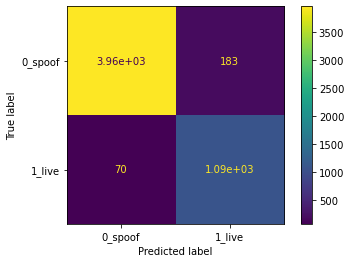

In [33]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix=cf_matrix, display_labels=label2cat).plot(values_format='.3g')

# Calculate Metric

In [34]:
apcer = fp / (tn + fp)
npcer = fn / (fn + tp)

acer = (apcer + npcer) / 2
tpr = tp / (tp + fn)
tnr = tn / (tn+fp)

In [35]:
print(f'APCER / FPR: {apcer*100:.{4}f}')
print(f'NPCER / FNR: {npcer*100:.{4}f}')
print(f'ACER: {acer*100:.{4}f}')
print(f'TPR: {tpr*100:.{4}f}')
print(f'TNR: {tnr*100:.{4}f}')

APCER / FPR: 4.4160
NPCER / FNR: 6.0554
ACER: 5.2357
TPR: 93.9446
TNR: 95.5840


In [36]:
from PIL import Image

In [37]:
img = Image.open('test.png')
label = 0
map_size=7
label_weight=0.99
if label == 0:
    mask = np.ones((1, map_size, map_size), dtype=np.float32) * (1 - label_weight)
else:
    mask = np.ones((1, map_size, map_size), dtype=np.float32) * (label_weight)

In [ ]:
mask